In [3]:
from astropy import table
import numpy as np
from pathlib import Path
from scipy import stats
import betterplotlib as bpl

bpl.set_style()

In [4]:
def get_all_catalogs(catalog_prefix):
    tables = []
    data_dir = Path("../data").resolve()
    for galaxy_dir in data_dir.iterdir():
        size_dir = galaxy_dir / "size"
        for file in size_dir.iterdir():
            if catalog_prefix in file.name and file.suffix == ".h5":
                new_table = table.Table.read(file, format="hdf5")
                new_table["galaxy"] = galaxy_dir.name
                tables.append(new_table)
    return tables

In [6]:
cats_old = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_thetascale1e2_noaprior_noqprior_multiplestarts")
cats_new = get_all_catalogs("radialweighting3pix_abs_bgscale1e3_nopriorsatall_multiplestarts_luminosity_powell")

In [7]:
big_table_old = table.vstack(cats_old, join_type="inner")
big_table_new = table.vstack(cats_new, join_type="inner")

In [21]:
def get_mad(big_table):
    std_cols = []
    mad_cols = []
    for col in big_table.colnames:
        if "x0_variations" in col:
            std_col = col.replace("x0_variations", "x0_std")
            mad_col = col.replace("x0_variations", "x0_mad")

            big_table[std_col] = np.std(big_table[col], axis=1)
            big_table[mad_col] = stats.median_abs_deviation(big_table[col], axis=1)

            std_cols.append(std_col)
            mad_cols.append(mad_col)

    std_cols = std_cols[2:]  # throw out full image xy, keep snapshot xy
    mad_cols = mad_cols[2:]  # throw out full image xy, keep snapshot xy
    # throw out luminosity/surface brightnes
    del mad_cols[2]
    
    return mad_cols

In [22]:
mad_cols = get_mad(big_table_old)
mad_cols = get_mad(big_table_new)
# This is just the list of column names

In [26]:
def make_cumulative_histogram(values):
    """
    Create the line to be plotted for a cumulative histogram

    :param values: data
    :return: List of xs and ys to be plotted for the cumulative histogram
    """
    sorted_values = np.sort(values)
    ys = np.arange(1, 1 + len(sorted_values), 1)
    assert len(ys) == len(sorted_values)
    return sorted_values, ys / np.max(ys)

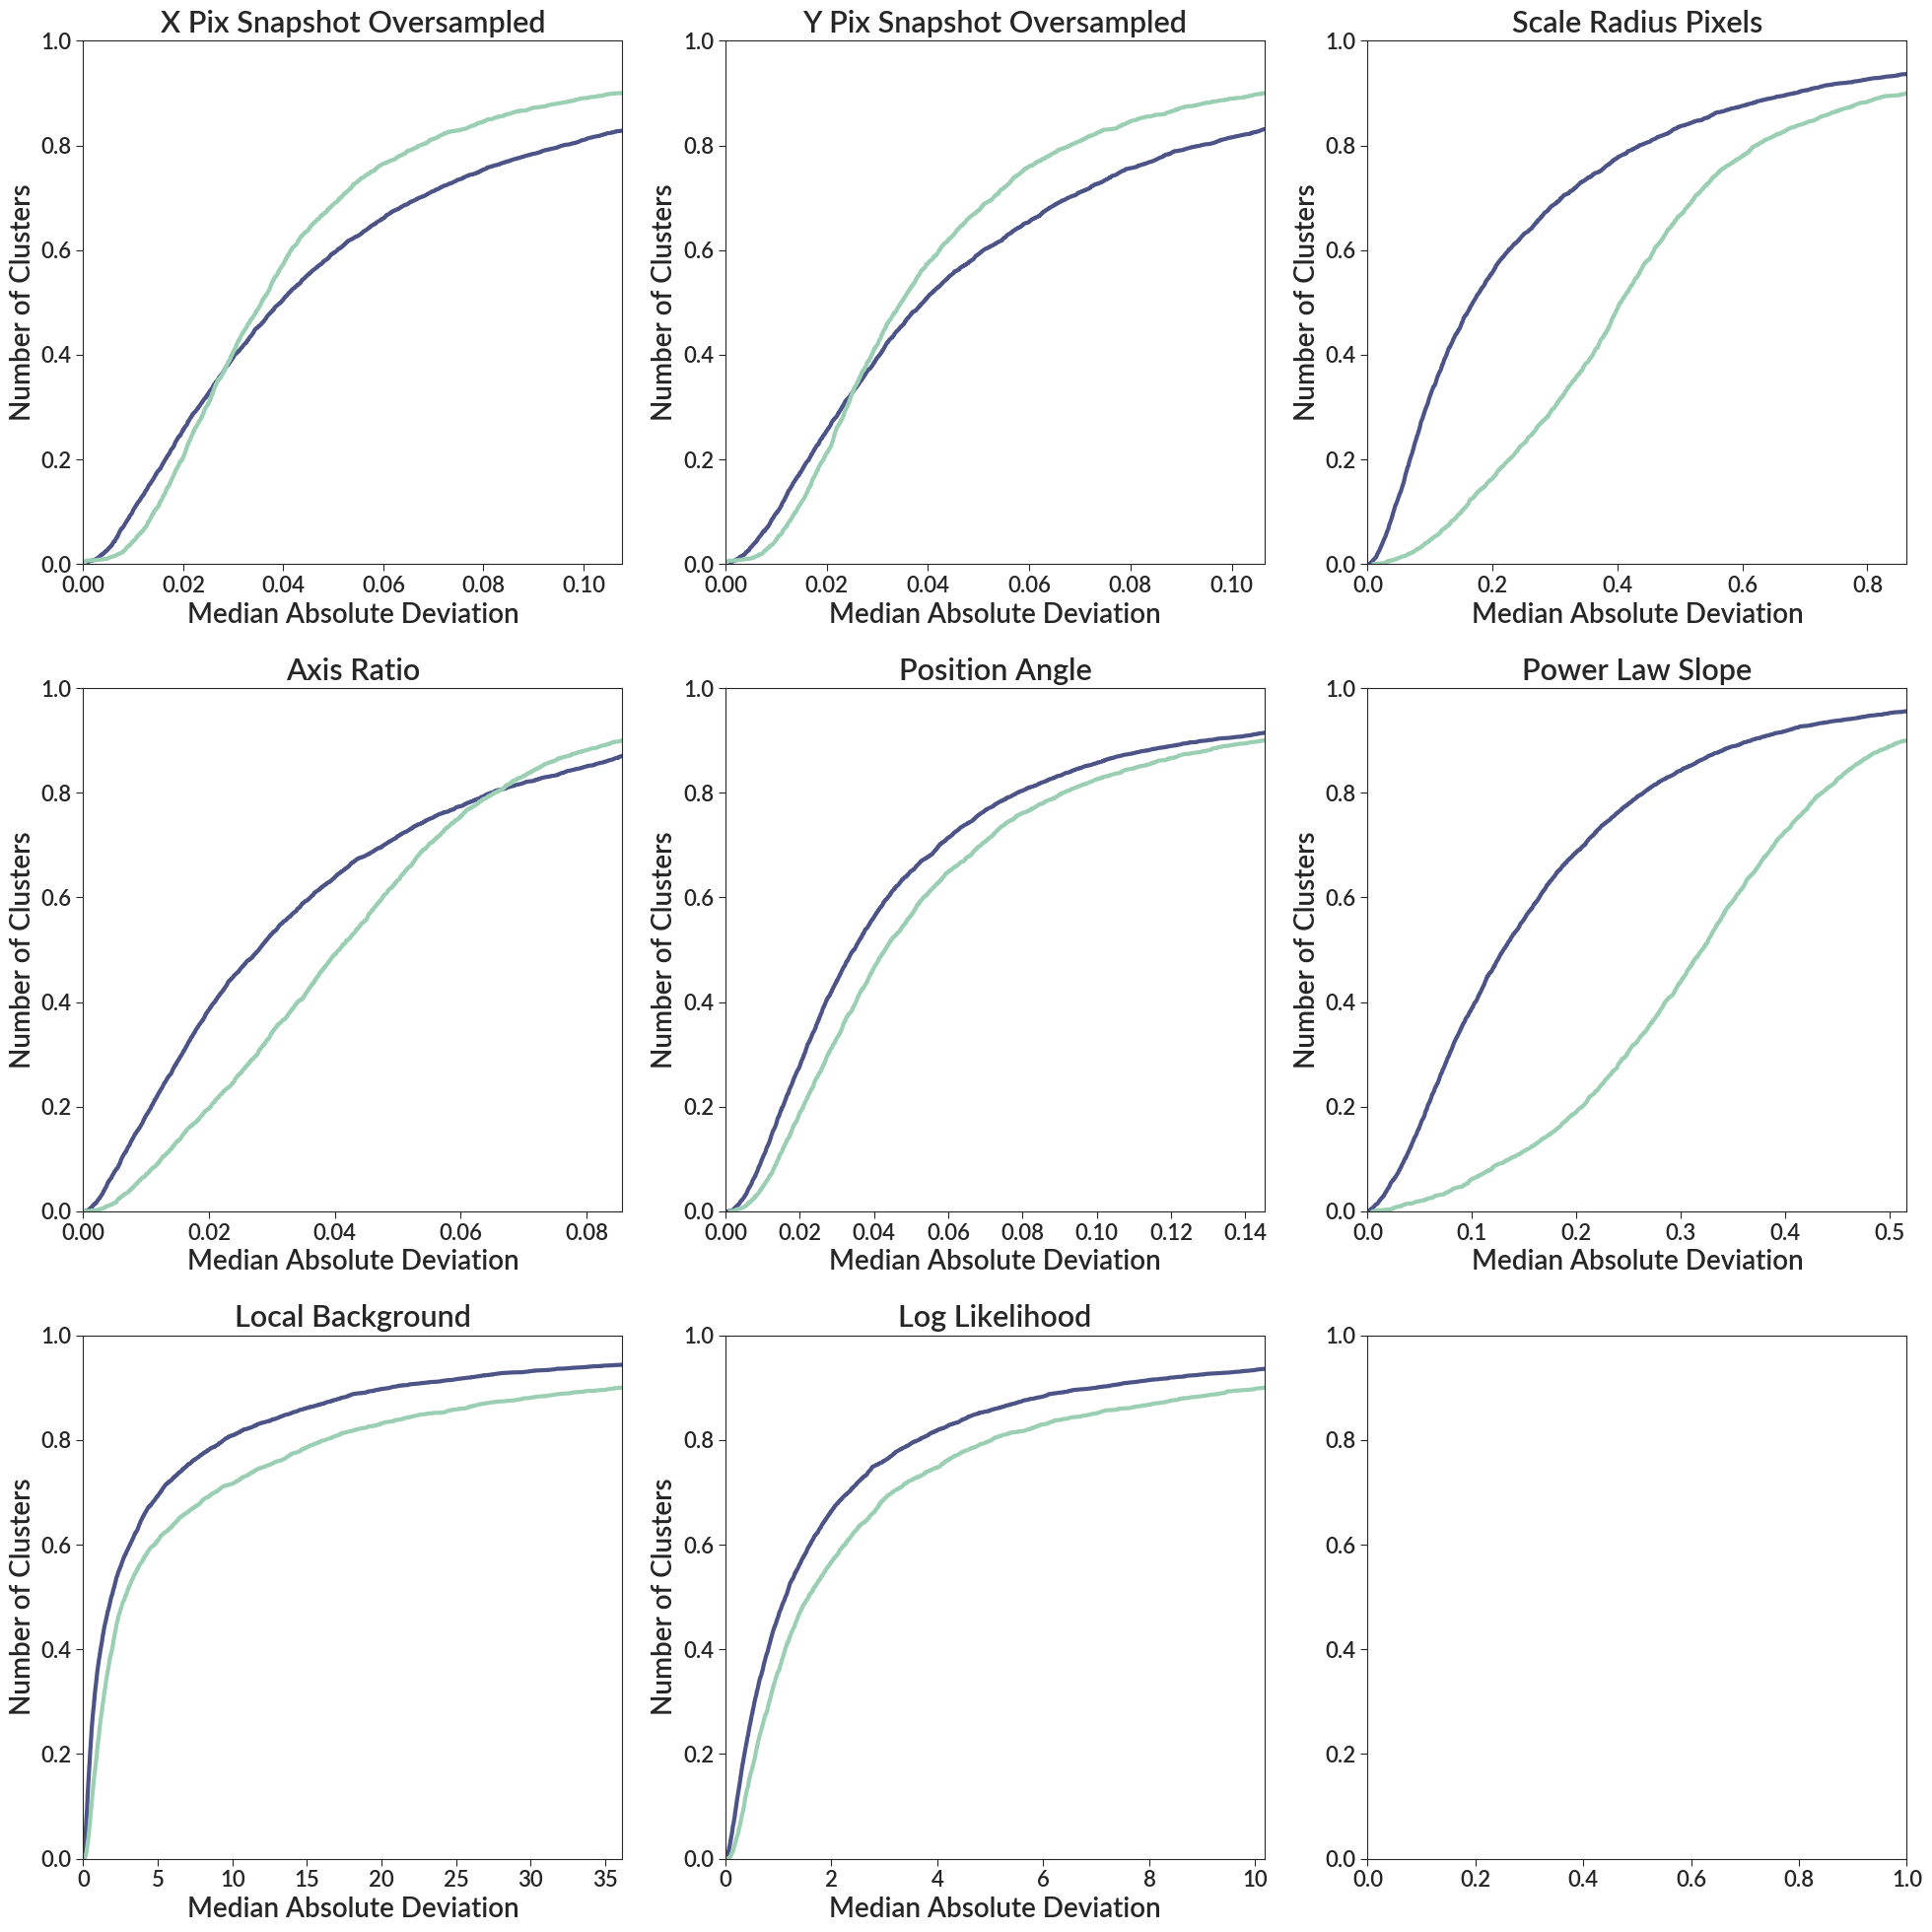

In [32]:
fig, axs = bpl.subplots(ncols=3, nrows=3, figsize=[20, 20])
axs = axs.flatten()
for ax, col in zip(axs, mad_cols):
    data_old = big_table_old[col]
    data_new = big_table_new[col]
    
    ax.plot(*make_cumulative_histogram(data_old), label="Old")
    ax.plot(*make_cumulative_histogram(data_new), label="Old")
    name = col[:-7].replace("_", " ").title()
    ax.add_labels("Median Absolute Deviation", "Number of Clusters", name)
    ax.set_limits(0, np.percentile(data_new, 90), 0, 1)

# Punchline is that things are not convergin

In [64]:
def create_differential_log_likelihoods(big_table):
    full_sort = np.sort(big_table["log_likelihood_x0_variations"].data, axis=1)[:,::-1]

    for i in range(1, len(full_sort[0])):
        big_table[f"delta_log_likelihood_{i}"] = full_sort[:,0] - full_sort[:,i]
        


In [65]:
create_differential_log_likelihoods(big_table_old)
create_differential_log_likelihoods(big_table_new)

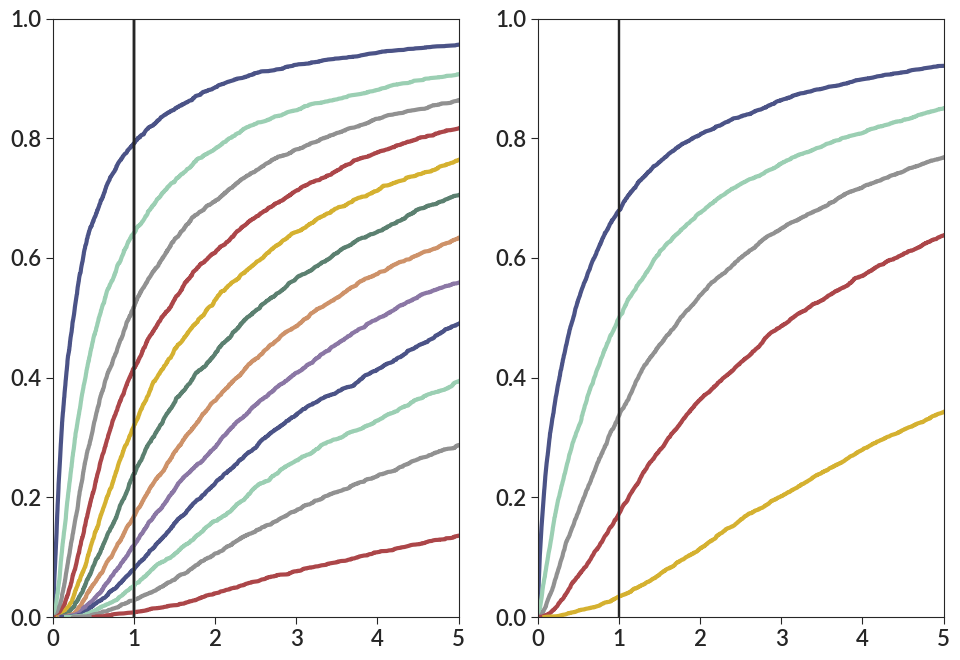

In [73]:
fig, axs = bpl.subplots(ncols=2)
for i in range(1, 13):
    axs[0].plot(*make_cumulative_histogram(big_table_new[f"delta_log_likelihood_{i}"]))
    axs[0].axvline(1)
for i in range(1, 6):
    axs[1].plot(*make_cumulative_histogram(big_table_old[f"delta_log_likelihood_{i}"]))
    axs[1].axvline(1)

for ax in axs:
    ax.set_limits(0, 5, 0, 1)